In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda
from tqdm import notebook
import scipy.optimize
from mpl_toolkits.mplot3d import Axes3D

In [31]:
step = 2 # Step of integration in fs
write_freq = 5000 # Number of steps that elapse between writing coordinates to output trajectory file
interval = int(500000/(step*write_freq)) # Interval to compute new normal to membrane plane (0.5 ns)
#interval = 50
s = 0 # in ps
e = 4000 # in ps
#e = 500000 # in ps
start_frame = int(s/step)
end_frame = int(e/step)

In [9]:
membrane = 'lipodisk_npt.gro'
traj = 'lipodisk_npt_2_whole_cluster_nojump_mol.xtc'
universe = mda.Universe(membrane, traj)

selection_planefit = 'not resid 111 106 and resname DMPC and name P'
plane_group = universe.select_atoms(selection_planefit)

In [3]:
def fitPlaneLTSQ(XYZ):
    (rows, cols) = XYZ.shape
    G = np.ones((rows, 3))
    G[:, 0] = XYZ[:, 0]  #X
    G[:, 1] = XYZ[:, 1]  #Y
    Z = XYZ[:, 2]
    (a, b, c),resid,rank,s = np.linalg.lstsq(G, Z)
    normal = (a, b, -1)
    nn = np.linalg.norm(normal)
    normal = normal / nn
    return (c, normal)

def calculate_S(coordinates, normal):
    cd = np.concatenate((coordinates[1::3]-coordinates[0::3], coordinates[2::3]-coordinates[0::3]), axis=0)
    cd_r = np.sqrt(np.sum(np.power(cd,2), axis=1))
    matrix_multiply = np.matmul(cd,normal)
    cos_theta = matrix_multiply/cd_r
    S_cd = -0.5*(3.*np.square(cos_theta)-1)
    order_param = np.average(S_cd)
    return order_param

In [4]:
LOP_group_all = {}
LOP_group_inner = {}
LOP_group_outer = {}
for atom_number in ['2','3','4','5','6','7','8','9','10','11','12','13','14']:
    selection_all = 'not resid 111 106 and resname DMPC and (name C2{0} or name H{0}R or name H{0}S or name C3{0} or name H{0}X or name H{0}Y)'.format(atom_number)
    selection_inner = 'not resid 111 106 and resname DMPC and (name C2{0} or name H{0}R or name H{0}S or name C3{0} or name H{0}X or name H{0}Y) and not same resid as (around 10 resname MAL MAR ST1 ST2 DB1 DB2 MAD MA2)'.format(atom_number)
    selection_outer = 'not resid 111 106 and resname DMPC and (name C2{0} or name H{0}R or name H{0}S or name C3{0} or name H{0}X or name H{0}Y) and same resid as (around 10 resname MAL MAR ST1 ST2 DB1 DB2 MAD MA2)'.format(atom_number)
    LOP_group_all[atom_number] = universe.select_atoms(selection_all)
    LOP_group_inner[atom_number] = universe.select_atoms(selection_inner)
    LOP_group_outer[atom_number] = universe.select_atoms(selection_outer)

In [32]:
data_all = pd.DataFrame(columns = ['C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14'])
data_inner = pd.DataFrame(columns = ['C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14'])
data_outer = pd.DataFrame(columns = ['C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14'])

for ts in notebook.tqdm(universe.trajectory):
    if (ts.frame >= start_frame) and (ts.frame <= end_frame):
        if ts.frame%interval == 0:
            positions = plane_group.atoms.positions[:]
            c, normal = fitPlaneLTSQ(positions)

        OP_list_all = []
        OP_list_inner = []
        OP_list_outer = []
        for atom_number in ['2','3','4','5','6','7','8','9','10','11','12','13','14']:
            # ALL
            coordinates_all = LOP_group_all[atom_number].atoms.positions[:]
            order_param_all = calculate_S(coordinates_all,normal)
            OP_list_all.append(order_param_all)
            # INNER
            coordinates_inner = LOP_group_inner[atom_number].atoms.positions[:]
            order_param_inner = calculate_S(coordinates_inner,normal)
            OP_list_inner.append(order_param_inner)
            # OUTER
            coordinates_outer = LOP_group_outer[atom_number].atoms.positions[:]
            order_param_outer = calculate_S(coordinates_outer,normal)
            OP_list_outer.append(order_param_outer)
        # ALL    
        a_series_all = pd.Series(OP_list_all, index = data_all.columns)
        data_all = data_all.append(a_series_all, ignore_index=True)
        # INNER
        a_series_inner = pd.Series(OP_list_inner, index = data_inner.columns)
        data_inner = data_inner.append(a_series_inner, ignore_index=True)
        # OUTER
        a_series_outer = pd.Series(OP_list_outer, index = data_outer.columns)
        data_outer = data_outer.append(a_series_outer, ignore_index=True)
    elif ts.frame > end_frame:
        break

/home/tarasov/Software/anaconda2/envs/mdaenv/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


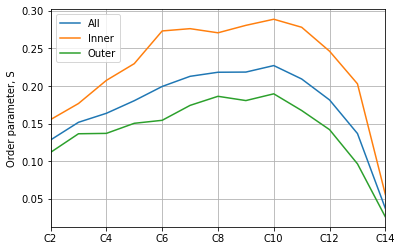

In [33]:
data_all.mean().rename('All').plot(legend='True')
data_inner.mean().rename('Inner').plot(legend='True')
data_outer.mean().rename('Outer').plot(legend='True')
plt.ylabel(u"Order parameter, S")
plt.grid()
#plt.show()
plt.savefig('Lipid_OP_dynamics.png')